### Imports

[Small description of all the imports we do]

In [1]:
# Useful starting lines
import numpy as np
import seaborn as sns
from util.dataloader import *
from util.finance import *
from util.plots import *
from util.quotebankexploration import *
from util.wikipedia import *
import plotly.graph_objects as go
import plotly.io as pio
import plotly.express as px
import numpy as np

from util.apple_stores import *

from task1 import *
from task2 import *
from task3 import *
from task4 import *

%load_ext autoreload
%autoreload 2

In [2]:
pio.renderers.default = "notebook_connected"

# <a class="anchor" id="TOC"></a> Table of Contents

***

* 0. [Introduction](#intro)
* 1. [Loading the datasets](#sect_1)
    * 1.1 [Apple stock : yFinance API](#sect_1_1)
    * 1.2 [Quotebank dataset](#sect_1_2)
* 2. [First look into the Apple stock market and related quotes](#sect_2)
    * 2.1 [Observations on the volatility, liquidity traded and media discussion](#sect_2_1)
    * 2.1 [Finding patterns and studying correlated features](#sect_2_2)
* 3. [Sentiment Analysis of Apple related quotes](#sect_3)
* 4. [Impact of the number of pageviews on the speakers' Wikipedia page](#sect_4)
    * 4.1 [Wiki labels and wiki ID](#sect_4_1)
    * 4.2 [Number of wiki page views](#sect_4_2)
    * 4.3 [Exact label for each quotes](#sect_4_3)
    * 4.4 [Scoring quotes](#sect_4_4)
    * 4.5 [Get back sentiment analysis](#sect_4_5)
    * 4.6 [Final scoring](#sect_4_6)
    * 4.7 [Final plot](#sect_4_7)

# 0. Introduction <a class="anchor" id="intro"></a>
[Back to table of contents](#TOC)

***

This notebook is intended to show and demonstrate the thought process that went into this project, on identifying patterns and correlations in stock markets and media quotes. In particular we have focused on the Apple Stock market, as it is one of the most valuable company on earth and it is widely covered in the media. 

# 1. Loading the datasets <a class="anchor" id="sect_1"></a>
[Back to table of contents](#TOC)

***

In this project we have studied three datasets to provide more insights in the stock price evolution, the coverage of Apple in the media, and its relationship with the various speakers. This first session is dedicated to loading the various datasets and preprocessing the valuable information.

### 1.1 Apple stock : yFinance API <a class="anchor" id="sect_1_1"></a>
[Back to table of contents](#TOC)

The yFinance API is provided by Yahoo Finance and provides an easy access to various financial metrics for most stocks in the market. The _ticker_ of the Apple stock is denoted _AAPL_, and we will first focus on a date range from 2010 up to 2020. We also provide an additional indicator of the daily volatility with the ``Liquidity`` field, which is the daily volume multiplied by the average daily stock price. This indicator in dollars is appropriate to have a quick overview on the quantity of Apple stock traded in a day, as a day of high liquidity is also said to be a day of high volatility. 

In [3]:
# Using yFinance API we load various metrics of the Apple stock ranging from 2008 to 2020
stock = load_stock("AAPL", 2008, 2020)

# We set a day of high volatility as a day among the highest 2% of liquidity in that year.
stock = high_volatility(stock, quantile = 0.98)

display(stock)

,Date,Open,High,Low,Close,Adj Close,Volume,Liquidity,Yearly Percentile
0,2008-09-02,6.157143,6.196429,5.892857,5.935357,5.088767,780763200,4.720690e+09,Lower 98%
1,2008-09-03,5.958571,6.024286,5.857143,5.962857,5.112345,734834800,4.380140e+09,Lower 98%
2,2008-09-04,5.923571,5.996786,5.743214,5.757857,4.936587,743386000,4.341905e+09,Lower 98%
3,2008-09-05,5.663929,5.800000,5.630357,5.720714,4.904742,786884000,4.479197e+09,Lower 98%
4,2008-09-08,5.877500,5.888929,5.409286,5.640000,4.835538,1045979200,6.023533e+09,Lower 98%
...,...,...,...,...,...,...,...,...,...
2951,2020-05-22,78.942497,79.807503,78.837502,79.722504,78.955223,81803200,6.489652e+09,Lower 98%
2952,2020-05-26,80.875000,81.059998,79.125000,79.182503,78.420425,125522000,1.004537e+10,Lower 98%
2953,2020-05-27,79.035004,79.677498,78.272499,79.527496,78.762085,112945200,8.954437e+09,Lower 98%
2954,2020-05-28,79.192497,80.860001,78.907501,79.562500,78.796761,133560800,1.060172e+10,Lower 98%


### 1.2 Quotebank Dataset <a class="anchor" id="sect_1_2"></a>
[Back to table of contents](#TOC)

The Quotebank data is a large text corpus of more than 178 millions quotations scrapped over 337 websites. As we are focusing on Apple related quotations, we have applied a various amount of filtering to reduce the number of quotes to 310'816. Some of the various techniques employed: 
1. White list of words that should be contained in quotes : _Apple_, _iPhone_, _Macbook_ etc.
2. Black list of words that should not be contained : _Mac n Cheese, _apple_, _Big Apple_ etc.
3. White list of speakers, as we also included speakers related to Apple regardless of the aforementioned white words : _Steve Jobs_, _Tim Cook_, _Steve Wozniak_ etc.

This final dataset of Apple related quotes have been saved in a `pkl` file to improve the ease of manipulation, and can be accessed with the `get_filtered_quotes` function.

In [4]:
quotes = get_filtered_quotes()

display(quotes)

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase
0,2008-10-15-012147,five times the graphics performance.,steve jobs,[Q19837],2008-10-15 06:38:46,2,"[[steve jobs, 0.7707], [None, 0.2293]]",[http://us.rd.yahoo.com/dailynews/rss/search/m...,A
1,2008-09-25-038377,my iphone is full of pictures. i wanted to see...,ken whisenhunt,[Q1758635],2008-09-25 08:08:08,1,"[[ken whisenhunt, 0.3759], [None, 0.3186], [ma...",[http://azcentral.com/arizonarepublic/sports/a...,A
2,2008-09-04-052789,the people who connect needs and ideas the bes...,steve jobs,[Q19837],2008-09-04 18:19:47,1,"[[steve jobs, 0.717], [None, 0.283]]",[http://businessweek.com/magazine/content/07_4...,A
3,2008-11-10-038937,sesame workshop will get 70 percent of the rev...,robert macmillan,"[Q21453558, Q28094302]",2008-11-10 22:59:44,1,"[[robert macmillan, 0.6071], [None, 0.3929]]",[http://macdailynews.com/index.php/weblog/comm...,A
4,2008-09-26-048683,the huge success of the apple itunes app store...,steve howard,"[Q23670647, Q2457386, Q7612886]",2008-09-26 11:29:23,1,"[[steve howard, 0.5034], [None, 0.4966]]",[http://ipod.consumerelectronicsnet.com/articl...,A
...,...,...,...,...,...,...,...,...,...
310811,2020-03-06-004716,Apple continues to show their tremendous suppo...,none,[],2020-03-06 01:14:31,2,"[[None, 0.6748], [Octavia Spencer, 0.2615], [M...",[https://www.denofgeek.com/tv/truth-be-told-se...,E
310812,2020-01-21-010221,"But at the same time, we're also not saying th...",satya nadella,[Q7426870],2020-01-21 15:44:24,1,"[[Satya Nadella, 0.8487], [None, 0.1513]]",[https://www.theverge.com/2020/1/21/21071108/m...,E
310813,2020-01-22-079970,The Big Mac burger sauce is so hard to get hol...,none,[],2020-01-22 12:34:13,2,"[[None, 0.8268], [Big Mac, 0.1733]]",[https://www.mirror.co.uk/money/shopping-deals...,E
310814,2020-04-01-004824,Archie has been loving doing FaceTime playdate...,none,[],2020-04-01 12:14:50,1,"[[None, 0.6707], [Prince Harry, 0.2197], [Megh...",[https://www.pinkvilla.com/entertainment/holly...,E


# 2. First look into the Apple stock market and related quotes <a class="anchor" id="sect_2"></a>
[Back to table of contents](#TOC)

One of the objectives of this project is to find patterns and events in both the stock market and media discussion related to Apple. `[peut être faire une bonne introduction de ce que tu vas faire, bien expliqué les objectifs et ce que tu veux à la fin]`

***

### 2.1 Observations on the volatility, liquidity traded and media discussion <a class="anchor" id="sect_2_1"></a>
[Back to table of contents](#TOC)

To proceed on this, we need metrics and qualitative visualization of the aforementioned data. To find days of interest in the stock market, we introduce the _Liquidity_, which is the mean price day multiplied by the daily volume of exchange. This indicator provides an intuition of the amount of $AAPL stock exchanged in day. A day of high liquidity will be synonymous of a day of high volatility, which may indicate a particular event related to Apple.

In the following plot we highlight the yearly top 2% of the liquidity days. In other words, we will observe each year the days with the highest liquidity. We observe a pattern that will be further studied, as the iPhone september events, or the quarterly reports. 

In [5]:
weekly_liquidity(stock, quantile=0.98)

Naturally we proceed on this comparison of high exchange days by looking at the daily price of the $AAPL stock. We highlight the same days of high volatility from the previous figures but next to the stock price instead of the liquidity. The intuition is that a day of high volatility may have repercussions on the stock price, either as a price fall or a rebound. 

In [6]:
daily_stock_price(stock)

Finally we will take a look at the filtered Quotebank dataset, which only describes Apple related quote. In the same idea as previous plots, we can highlight the yearly top 2% of days with the most quotes. Again we can observe some patterns, that will be further dissected in the next few sections. For example we observe a yearly spike in September when the new iPhone is released, or in June with the yearly developer conference. Most importantly the highest spike the 6th October 2011 is related to Steve Jobs death, which was widely covered in the media.

In [7]:
daily_quotes(quotes, quantile = 0.98)

### 2.2 Finding patterns and studying correlated features <a class="anchor" id="sect_2_2"></a>
[Back to table of contents](#TOC)

From the above observations, we had the intuition that each quarter report release by Apple was synonymous with a day of high volatility. A quarterly report is a summary or collection of unaudited financial statements, such as  gross revenue, net profit, operational expenses, and cash flow. As we have 252 trading days in a year and 4 quarter reports per year, we expect a periodicity of high liquidity days of around $252/4 = 64$ days. This in fact validated by the next cell, which performs a seasonal analysis over a wide range of days period, and keep the days with the lowest null probability (i.e p-value). Later on we will see if these pattern is also observable on the Apple related quotes.

In [8]:
seasonal_analysis(stock[stock.Date.dt.year.isin([2018,2019])], column="Liquidity")

  0%|          | 0/120 [00:00<?, ?it/s]

The Liquidity can be fitted with a seasonal model of period 64 with p_value 6.639388969749278e-28


What we finally observe is that there is a qualitative correlation between the number of daily quotes related to Apple and the daily liquidity. The two are positively correlated, which indicates that an increase in liquidity will be likely associated with an increase in discussion related to Apple and the other way around. 

In [9]:
stock_price_with_quotes(stock,quotes)

In [10]:
pearson_stock_quotes(stock[stock.Date.dt.year.isin(range(2015,2019))],quotes)

(0.315489221804481, 8.207856553749298e-24)

# 3. Sentiment Analysis of Apple related quotes <a class="anchor" id="sect_3"></a>
[Back to table of contents](#TOC)

***

In [30]:
quotes_sentiments = predict_sentiment(quotes)

In [31]:
correlation_stock_sentiment(quotes_sentiments,stock)


Pearson pos (0.21461460243489497, 6.647184376858403e-31)
Pearson neg (0.1653123185728737, 1.844836520952423e-18)
Pearson neut (0.219254806691941, 7.580016059361478e-32)


In [39]:
from task3 import *

fig_all_sentiments(quotes_sentiments,stock)

# 4. Impact of the number of pageviews on the speakers' Wikipedia page <a class="anchor" id="sect_4"></a>
[Back to table of contents](#TOC)

***

Now we have looked the positiveness of the different quotes of our data set, we want to add more depth about on the impact of the quotes on the stock market. To do so, we pose to ourselves the following question: What is the impact of a quote on others ? The response is relatively simple, it depends on how well known the speaker was at the time he or she was quoted in the media. And a quite simple way to have that indicators is the number of pageviews on then speakers' Wikipedia page (if there is one !).

#### 4.1 Wiki labels and wiki ID <a class="anchor" id="sect_4_1"></a>
[Back to table of contents](#TOC)

But before accessing to this number of pageviews, we need the exact label of the speakers' Wikipedia page. And for that, we will load the following data set that particularly contains the precise label's page for its ocrresponding wiki ID that we have for each quotes in our quotes' data set. 

In [14]:
# Get the wiki labels with its corresponding wiki ID
wiki_labels = get_wiki_labels()[['id', 'label']]
display(wiki_labels.head(5))

,id,label
0,Q23,George Washington
1,Q42,Douglas Adams
2,Q1868,Paul Otlet
3,Q207,George W. Bush
4,Q297,Diego Velázquez


#### 4.2 Number of wiki page views <a class="anchor" id="sect_4_2"></a>
[Back to table of contents](#TOC)

After that, we need a way to get the number of pageviews of some speaker for a specific year. For that we use the package `pageviewapi` that gives us all the wiki page views from 2015. We would have liked to have all the pageviews since 2008, but it was too complicated and one person cerate a way to get these data, but the website was not able to work anymore. Then, we had focus our study between 2015 and 2020, and we had design a fucntion that returns the number of pageviews of a specific wiki page and year. This is what follows.

In [15]:
# Get the page views for the Steve Jobs wikipedia page in 2015
speaker = 'Steve Jobs'
year = 2015
print(get_pageviews_per_year(speaker, year))

6365607


#### 4.3 Exact label for each quotes <a class="anchor" id="sect_4_3"></a>
[Back to table of contents](#TOC)

The idea now is to get the exact label for each speaker of every single quotes in our quotes data set. This can be done directly by merging the ID in `wiki_labels` with the QID of the data frame `quotes`, but here it's not that simple. The different quotes of our data set given by quotebank has more than one QID because the name of the speaker can be confusing with another speaker, so it gives the two QID in the list for that quote. To deal with this issue, we decided to use look at all the different QID for each quotes, and keep the label that corresponds to the speaker having the maximum number of total pageviews. 

Before that, we get all the speakers' ID that are given for each quotes in our data set.

In [16]:
# Get the speakers' ID
speakers_id = get_speakers_ids(quotes)
speakers_id_sample = speakers_id.head(5)
display(speakers_id_sample)

,speaker,qids
0,steve jobs,[Q19837]
1,ken whisenhunt,[Q1758635]
2,robert macmillan,"[Q21453558, Q28094302]"
3,steve howard,"[Q23670647, Q2457386, Q7612886]"
4,doug martin,"[Q18685889, Q27995830, Q3037945, Q3714598, Q53..."


Here we can clearly see that for one speaker for oour quotes, there might have more than one QID. So here is in the following cell the process we applied to get for all speakers the true label in Wikipedia.

**Remark :** The following cell show how the process is done over a sample the dataframe `quotes`. We do not do the whole filtering here because the run is about 22h, so we did it once on multiple clusters and save it in a `.pkl` file. The run is so long because of the `pageviewapi` we call at each iteration at least once, to get the number of pageview for the considered QID.

In [17]:
# Get the right label of the speakers of each quotes.
# It adds a new column `label` in quotes dataframe containig the wiki label of the speaker.
speakers_labels_sample = find_labels(speakers_id_sample, wiki_labels)
display(speakers_labels_sample)

# Get the whole data set from a .pkl file
speakers_labels = get_speakers_labels()

100%|██████████| 5/5 [00:23<00:00,  4.69s/it]


,speaker,qids,label
0,steve jobs,[Q19837],Steve Jobs
1,ken whisenhunt,[Q1758635],Ken Whisenhunt
2,robert macmillan,"[Q21453558, Q28094302]",Robert MacMillan
3,steve howard,"[Q23670647, Q2457386, Q7612886]",Steve Howard
4,doug martin,"[Q18685889, Q27995830, Q3037945, Q3714598, Q53...",Doug Martin


#### 4.4 Scoring quotes <a class="anchor" id="sect_4_4"></a>
[Back to table of contents](#TOC)

Now we have the exact label of the spaker of each quotes, we want to get the number of the speaker's wiki page views at the year where the quote was published. So the idea is simple: we just take the label and the year of each quotes and use the function `get_pageviews_per_year` to add a new column `score` in our data frame.

**Remark :** As in the previous subsection, here is an example ofhow the process works on a small smaple of the data set because is too long (around 8h for this one). Since the large runnning time, we decided to split the steps such taht we can run it on multiple computer. The idea was then, to get pageviews for each speaker for every year between 2015 and 2020. Here is a sample of how the code works.

In [18]:
# Apply the process on a small sample
speakers_pageviews_sample = get_speakers_pageviews_per_year(speakers_labels_sample)
display(speakers_pageviews_sample)

# Load the whole data set from a pickle file
speakers_pageviews = get_speakers_pageviews()

,speaker,qids,label,2015,2016,2017,2018,2019,2020
0,steve jobs,[Q19837],Steve Jobs,6365607,9536391,7605088,6458359,6362619,6900472
1,ken whisenhunt,[Q1758635],Ken Whisenhunt,135492,115367,86274,132915,113473,81236
2,robert macmillan,"[Q21453558, Q28094302]",Robert MacMillan,498,1111,946,884,835,1152
3,steve howard,"[Q23670647, Q2457386, Q7612886]",Steve Howard,9700,23643,19157,17095,18213,21539
4,doug martin,"[Q18685889, Q27995830, Q3037945, Q3714598, Q53...",Doug Martin,3276,6785,3220,6103,1841,1242


Now, we directly join the year of the quotes with the corresponding number of pageviews of the speakers. After that we normalize the value and we then obtain a score for each quotes (in absolute value for now).

**Remark :** The process here do not use the `pageviewapi` package, so it is pretty fast then we can directly do it on the whole data frame.

In [19]:
# Add score column for our data frame
quotes_score = get_score_quotes(quotes, speakers_pageviews)
display(quotes_score.head(5))

,speaker,quoteID,quotation,qids_left,date,numOccurrences,probas,urls,phase,qids_right,label,pageviews,score
0,2 chainz,2018-09-10-038202,I want to send condolences to Mac Miller's fam...,[Q129668],2018-09-10 11:44:18,1,"[[2 Chainz, 0.8386], [None, 0.1492], [Mac Mill...",[https://rollingout.com/2018/09/10/2-chainz-cl...,E,[Q129668],2 Chainz,761.0,0.000003
1,21 savage,2016-12-13-038368,I got more followers & more shooters than the ...,[Q25095399],2016-12-13 19:55:57,1,"[[21 Savage, 0.6807], [None, 0.2981], [Kylie J...",[http://urbanislandz.com/2016/12/13/21-savage-...,E,[Q25095399],21 Savage,1042616.0,0.004614
2,21 savage,2017-09-26-146262,We just have a long history of supporting Post...,[Q25095399],2017-09-26 14:04:09,1,"[[21 Savage, 0.4937], [None, 0.2597], [DJ Khal...",[https://forums.macrumors.com/threads/rapper-p...,E,[Q25095399],21 Savage,2302.0,0.000010
3,30 roc,2020-01-28-077235,"The day after the album came out, I went on iT...",[Q50352763],2020-01-28 19:17:20,5,"[[30 Roc, 0.8062], [None, 0.1938]]",[http://ctpost.com/entertainment/article/Hitma...,E,[Q50352763],30 Roc,1198574.0,0.005304
4,50 cent,2015-03-31-013537,Do we want to release the single on iTunes fir...,[Q6060],2015-03-31 16:20:43,1,"[[50 Cent, 0.908], [None, 0.092]]",[http://www.thecrimson.com/article/2015/3/31/k...,E,[Q6060],50 Cent,2051341.0,0.009077


#### 4.5 Get back sentiment analysis <a class="anchor" id="sect_4_5"></a>
[Back to table of contents](#TOC)

Now we have an absolute score value for each single quotes that representes approximately the impact of the quotes on the stock market, we want to know if the impact is positive, negative or neutral. For that we will use the function designed in the section 3.4 (mettre le numéro exacte de la section de camille) to get the valence of each quotes. In the following cell, we show how the process works to add a column `sentiment` to our dataframe.

In [20]:
# Add the column sentiment
quotes_sentiment = get_sentiment_quotes(quotes_score)
display(quotes_sentiment.head(5))

100%|██████████| 128672/128672 [00:21<00:00, 5930.40it/s]


,speaker,quoteID,quotation,qids_left,date,numOccurrences,probas,urls,phase,qids_right,label,pageviews,score,sentiment
0,2 chainz,2018-09-10-038202,I want to send condolences to Mac Miller's fam...,[Q129668],2018-09-10 11:44:18,1,"[[2 Chainz, 0.8386], [None, 0.1492], [Mac Mill...",[https://rollingout.com/2018/09/10/2-chainz-cl...,E,[Q129668],2 Chainz,761.0,0.000003,1
1,21 savage,2016-12-13-038368,I got more followers & more shooters than the ...,[Q25095399],2016-12-13 19:55:57,1,"[[21 Savage, 0.6807], [None, 0.2981], [Kylie J...",[http://urbanislandz.com/2016/12/13/21-savage-...,E,[Q25095399],21 Savage,1042616.0,0.004614,-1
2,21 savage,2017-09-26-146262,We just have a long history of supporting Post...,[Q25095399],2017-09-26 14:04:09,1,"[[21 Savage, 0.4937], [None, 0.2597], [DJ Khal...",[https://forums.macrumors.com/threads/rapper-p...,E,[Q25095399],21 Savage,2302.0,0.000010,1
3,30 roc,2020-01-28-077235,"The day after the album came out, I went on iT...",[Q50352763],2020-01-28 19:17:20,5,"[[30 Roc, 0.8062], [None, 0.1938]]",[http://ctpost.com/entertainment/article/Hitma...,E,[Q50352763],30 Roc,1198574.0,0.005304,-1
4,50 cent,2015-03-31-013537,Do we want to release the single on iTunes fir...,[Q6060],2015-03-31 16:20:43,1,"[[50 Cent, 0.908], [None, 0.092]]",[http://www.thecrimson.com/article/2015/3/31/k...,E,[Q6060],50 Cent,2051341.0,0.009077,1


#### 4.6 Final scoring <a class="anchor" id="sect_4_6"></a>
[Back to table of contents](#TOC)

Finally, we multiply the valence of the quotes with the absolute score to get a positive and negative score that we will sum along each single day. So we first create two columns `negative_score` and `positive_score` for each quotes. 

**Example :** If the quote has a negative valence, in column `negative_score`there will be the valence (-1) multiplied with the absolute score and in the column `positive_score` the value will be equal to zero.

In [21]:
# Add positive and negative score
quotes_neg_pos_score = get_neg_pos_score_quotes(quotes_sentiment)
display(quotes_neg_pos_score.head(5))

,speaker,quoteID,quotation,qids_left,date,numOccurrences,probas,urls,phase,qids_right,label,pageviews,score,sentiment,positive_score,negative_score
0,2 chainz,2018-09-10-038202,I want to send condolences to Mac Miller's fam...,[Q129668],2018-09-10 11:44:18,1,"[[2 Chainz, 0.8386], [None, 0.1492], [Mac Mill...",[https://rollingout.com/2018/09/10/2-chainz-cl...,E,[Q129668],2 Chainz,761.0,0.000003,1,0.000003,0.000000
1,21 savage,2016-12-13-038368,I got more followers & more shooters than the ...,[Q25095399],2016-12-13 19:55:57,1,"[[21 Savage, 0.6807], [None, 0.2981], [Kylie J...",[http://urbanislandz.com/2016/12/13/21-savage-...,E,[Q25095399],21 Savage,1042616.0,0.004614,-1,0.000000,-0.004614
2,21 savage,2017-09-26-146262,We just have a long history of supporting Post...,[Q25095399],2017-09-26 14:04:09,1,"[[21 Savage, 0.4937], [None, 0.2597], [DJ Khal...",[https://forums.macrumors.com/threads/rapper-p...,E,[Q25095399],21 Savage,2302.0,0.000010,1,0.000010,0.000000
3,30 roc,2020-01-28-077235,"The day after the album came out, I went on iT...",[Q50352763],2020-01-28 19:17:20,5,"[[30 Roc, 0.8062], [None, 0.1938]]",[http://ctpost.com/entertainment/article/Hitma...,E,[Q50352763],30 Roc,1198574.0,0.005304,-1,0.000000,-0.005304
4,50 cent,2015-03-31-013537,Do we want to release the single on iTunes fir...,[Q6060],2015-03-31 16:20:43,1,"[[50 Cent, 0.908], [None, 0.092]]",[http://www.thecrimson.com/article/2015/3/31/k...,E,[Q6060],50 Cent,2051341.0,0.009077,1,0.009077,0.000000


Then, we just sum the score along each day when we have quotes. And we keep only the coluns `date`, `positive_score` and `negative_score` for the final plot. The following cell show how the process is applied.

In [22]:
# Get the negative and positive score for every days
score_date = get_score_date(quotes_neg_pos_score)
display(score_date.head(5))

,date,positive_score,negative_score
0,2015-01-01,0.000079,-0.007516
1,2015-01-02,0.012737,-0.003240
2,2015-01-03,0.005720,-0.028335
3,2015-01-04,0.002935,0.000000
4,2015-01-05,0.009968,-0.011739


#### 4.7 Final plot <a class="anchor" id="sect_4_7"></a>
[Back to table of contents](#TOC)

And after all these steps, we can finally have a concrete visualization of our results. So the idea is to plot the `positive_score` and the `negative_score` depending of the `date`. And on the same figure, we plot the price of the Apple's stock price depending also of the `date`. The goal is to see if there is a visible correlation betwen the postive and negative score and the stock price. Here is the following plot.

In [23]:
stock_price_against_quotes_score(score_date, stock)

#### 4.8 Bapitou plot <a class="anchor" id="sect_4_8"></a>
[Back to table of contents](#TOC)

In [24]:
plot_distrib_val_fame(quotes_sentiment)

100%|██████████| 128672/128672 [00:20<00:00, 6318.58it/s] 


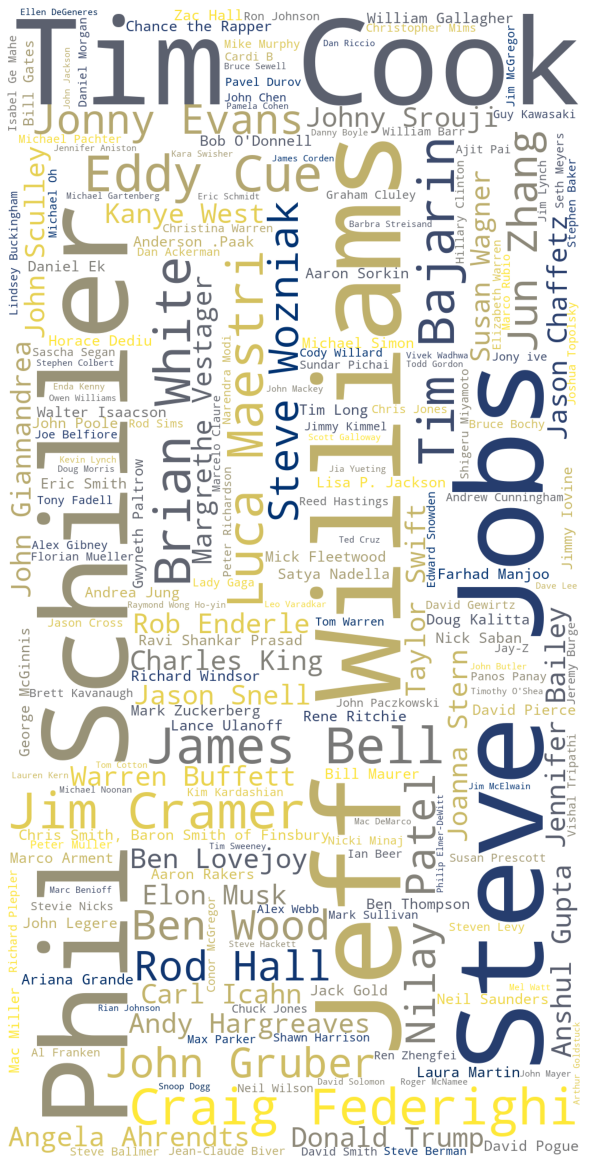

In [25]:
plot_wordcloud_speakers(quotes,speakers_pageviews)

----
# 5. Building a model for stock market prediction
Using the quotes related to Apple, speakers data and past stock performance, we can perform a first attempt at predicting the daily stock price and the liquidity. For this section we will use the Facebook's Prophet library, which provides powerful and easy to use forecasting tools. At its core, the model is a modular linear regression model, that can take into account past performance and additional factors. 

In [26]:
quotes_sentiment = pd.read_pickle("data/quotes_score.pkl")

prediction_frame = build_prediction_frame(stock[stock.Date.dt.year.isin(range(2015,2018))],quotes_sentiment)

m = fit_prophet(Prophet(changepoint_prior_scale=0.05, seasonality_prior_scale=0.1), prediction_frame, features=['positive','negative','total'], response='Open')
pred = predict_future(m,prediction_frame,feature_frame=quotes_sentiment)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


AttributeError: 'StanModel' object has no attribute 'fit_class'

In [ ]:
plot_prediction(stock, quotes_sentiment,pred)

In [ ]:
# Performance evaluation
df_cv = cross_validation(m, initial='150 days', period='30 days', horizon = '60 days',parallel="processes")
df_p = performance_metrics(df_cv)

print("Mean absolute percentage error in a first week horizon", df_p["mape"].values[0])


In [ ]:
times_series_predict(stock, quotes_sentiment, features = None, response = 'Open')

In [ ]:
param_grid = {  
  'changepoint_prior_scale': np.linspace(0.2,2,10) ,
  'seasonality_prior_scale': np.logspace(-2,1,10),
}

tuning_results = prophet_cross_validation(param_grid, stock, quotes_sentiment, features = ['positive','negative','total'], response = 'Open', metric = 'mape')
tuning_results[tuning_results.mape == tuning_results.mape.min()]